In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import progressbar
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

#### Merge 500 files and keep only relevant columns

In [ ]:
def mergeDatasets(file_count = 500):
    task_data = pd.read_csv("./task_events/part-00000-of-00500.csv.gz", compression='gzip', names = ["timestamp", "missing_info", "jobID", "task_index", "machineID", "event_type", "user_name", "sched_class", "priority", "CPU", "RAM", " disk_space", "diff_machine_constraint"])
    task_data = task_data[["timestamp", "missing_info", "jobID", "task_index", "machineID", "event_type", "priority", "diff_machine_constraint"]]
    for i in progressbar.progressbar(range(1, file_count)):
        file_name = "./task_events/part-%05d-of-00500.csv.gz" % (i)
        temp_data = pd.read_csv(file_name, compression='gzip', names = ["timestamp", "missing_info", "jobID", "task_index", "machineID", "event_type", "user_name", "sched_class", "priority", "CPU", "RAM", " disk_space", "diff_machine_constraint"])
        temp_data = temp_data[["timestamp", "missing_info", "jobID", "task_index", "machineID", "event_type", "priority", "diff_machine_constraint"]]
        task_data = task_data.append(temp_data)
#         print("Length of file %d = %d" % (i, len(task_data)))
    return task_data

In [ ]:
task_data = mergeDatasets(10)

In [ ]:
print("Total Records in table = %d" % len(task_data))

In [ ]:
task_data = task_data.drop(['missing_info', 'diff_machine_constraint'], axis = 1)

#### Remove records that involve tasks scheduled before the beginning of the trace

In [ ]:
unwanted_jobs = task_data[task_data['timestamp'] == 0]['jobID']
task_data = task_data[~task_data['jobID'].isin(unwanted_jobs)]
print ("Records after removal of pre-trace = %d" % len(task_data))

#### Convert columns to suitable types to reduce filesize

In [ ]:
def to_int(val):
    if np.isnan(val):
        return np.int64(0)
    else:
        return np.int64(val)

In [ ]:
task_data['priority'] = pd.to_numeric(task_data['priority'], downcast='signed', errors = 'coerce')
task_data['event_type'] = pd.to_numeric(task_data['event_type'], downcast='signed', errors = 'coerce')
task_data['priority'] = pd.to_numeric(task_data['priority'], downcast='signed', errors = 'coerce')
task_data['timestamp'] = task_data['timestamp'].astype(np.int64)
task_data['machineID'] = task_data['machineID'].map(to_int)

#### Save the file

In [ ]:
task_data.to_pickle('./reduced_task_data.gz')

#### Load the file

In [2]:
task_data = pd.read_pickle('./reduced_task_data.gz')

In [5]:
task_data.memory_usage(index=True).sum()

5193597150

#### Calculate the day passed since the start of the trace

In [6]:
def calculateDay(timestamp):
    # Start time is May 1 2011 (19:00 EDT). It is a Sunday
#     print d.year, d.month, d.day, d.hour, d.second
# datetime.datetime(year, month, day[, hour[, minute[, second[, microsecond[, tzinfo]]]]])¶
    start_date = datetime.datetime(2011, 5, 1, 19, 0)
    return start_date + timedelta(microseconds = timestamp)


#### Calculate hourly statistics (no_of_jobs, average priority, no. of machines)

In [22]:
def calculateHourlyUsage(data):
    cols = ['hour', 'no_of_jobs', 'avg_priority', 'machines_available']
    result = pd.DataFrame(columns=cols)
    print("started loading")
    for i in progressbar.progressbar(range(30 * 24)):
        range_min = i * 3600 * (10**6)
        range_max = (i + 1) * 3600 * (10**6)
        jobs_of_hour = data[(data['timestamp'] >= range_min) & (data['timestamp'] < range_max) & (data['event_type'] == 1)]
        no_of_jobs = len(jobs_of_hour['jobID'].unique())
        avg_priority = np.average(jobs_of_hour['priority'])
        machines = len(jobs_of_hour['machineID'].unique())
        output_data = pd.DataFrame(columns=['hour', 'no_of_jobs', 'avg_priority', 'machines_available'],data=[[i,no_of_jobs,avg_priority,machines]])
        result = result.append(output_data)
#         print(result)
#         print ("hour = ", i)
    return result

In [23]:
hourly_usage = calculateHourlyUsage(task_data)

N/A% (0 of 720) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

started loading


 96% (697 of 720) |##################### | Elapsed Time: 0:08:19 ETA:   0:00:16/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:1128: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100% (720 of 720) |######################| Elapsed Time: 0:08:35 Time:  0:08:35


In [26]:
hourly_usage

,hour,no_of_jobs,avg_priority,machines_available
0,0,564,1.942224,9332
0,1,753,1.938783,8654
0,2,688,1.911985,7553
0,3,893,1.311717,9829
0,4,774,1.473177,9587
0,5,1160,1.924207,9034
0,6,1030,1.259194,9181
0,7,795,1.465350,9866
0,8,550,1.507160,6204
0,9,682,1.474834,9748


#### Remove extra hours

In [27]:
hourly_usage = hourly_usage[hourly_usage['hour'] <= 696]

#### Calculate load as 

load = no_of_jobs * avg_priority / machines_available

In [28]:
hourly_usage['best_time'] = (hourly_usage['no_of_jobs'] * hourly_usage['avg_priority'])/hourly_usage['machines_available']

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
hourly_usage

,hour,no_of_jobs,avg_priority,machines_available,best_time
0,0,564,1.942224,9332,0.117383
0,1,753,1.938783,8654,0.168697
0,2,688,1.911985,7553,0.174162
0,3,893,1.311717,9829,0.119174
0,4,774,1.473177,9587,0.118936
0,5,1160,1.924207,9034,0.247076
0,6,1030,1.259194,9181,0.141267
0,7,795,1.465350,9866,0.118078
0,8,550,1.507160,6204,0.133614
0,9,682,1.474834,9748,0.103184


#### Plot the best_time value for each hour since the start of the trace

In [174]:
plt.plot(hourly_usage['hour'], hourly_usage['best_time'])
plt.xlabel('hours since start of trace')
plt.ylabel('Load')

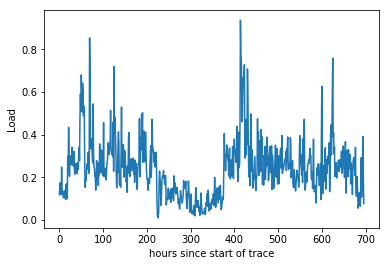

In [175]:
plt.show()

#### Finding the hour of the day (0 to 23)

In [97]:
hourly_usage['hour_in_day'] = (19 + hourly_usage['hour']) % 24

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [108]:
hourly_usage['hour'] = hourly_usage['hour'].astype(int)
hourly_usage['no_of_jobs'] = hourly_usage['no_of_jobs'].astype(int)
hourly_usage['machines_available'] = hourly_usage['machines_available'].astype(int)
hourly_usage['best_time'] = hourly_usage['best_time'].astype(float)
hourly_usage['hour_in_day'] = hourly_usage['hour_in_day'].astype(int)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [109]:
hourly_usage.dtypes

hour                    int64
no_of_jobs              int64
avg_priority          float64
machines_available      int64
best_time             float64
hour_in_day             int64
dtype: object

#### Finding mean stats by the hour of the day

In [112]:
grouped = hourly_usage.groupby('hour_in_day').mean()
grouped

,hour,no_of_jobs,avg_priority,machines_available,best_time
hour_in_day,,,,,
0,341.0,1318.586207,2.596094,10553.448276,0.330319
1,342.0,1058.241379,2.520734,10645.620690,0.252028
2,343.0,1011.413793,2.559668,10385.241379,0.245685
3,344.0,1009.862069,2.355730,10556.689655,0.226398
4,345.0,1189.724138,1.871763,10769.310345,0.208417
5,346.0,922.103448,1.869361,10570.275862,0.168835
6,347.0,902.379310,1.839595,10590.241379,0.162920
7,348.0,948.758621,2.272852,10583.793103,0.207083
8,349.0,1020.448276,2.312040,10793.172414,0.221324


#### Plot the hour of the day vs best_time stat

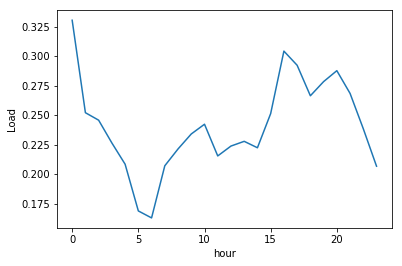

In [176]:
plt.plot(grouped.index, grouped['best_time'])
plt.xlabel('hour')
plt.ylabel('Load')
plt.show()

##### Observations: 6 AM - 7 AM has the least load 

#### Convert hours since start to days since start of trace

In [118]:
def hour_to_day(hour_input):
    start_date = datetime.datetime(2011, 5, 1, 19, 0)
    datee = start_date + timedelta(hours = hour_input)
    return datee.weekday()

In [119]:
hourly_usage['day_of_week'] = hourly_usage['hour'].map(hour_to_day)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [163]:
def findDay(hour_input):
    start_time = datetime.datetime(2011,5,1,19,0)
    datee = start_time + timedelta(hours = hour_input)
    difference = (datee.day - start_time.day)
    return difference
print(findDay(4))

0


#### Wald's Test

In [187]:
import math
def walds_test(L1,L2,mu1,mu2):
    # print mu1,mu2
    var1 = 0
    for v in L1:
        var1+=(v-mu1)*(v-mu1)
    var1=var1/float(len(L1))

    var2 = 0
    for v1 in L2:
        var2 += (v1 - mu2) * (v1 - mu2)
    var2 = var2 / float(len(L2))

    var = (var1/float(len(L1))) + (var2/float(len(L2)))

    var = math.sqrt(var)

    ans = (mu1-mu2) / float(var)
#     print "num",(mu1-mu2)
#     print "denom",var
    print("W value",ans)

In [191]:
# day_by_usage = hourly_usage.groupby(['day_of_week']).mean()
# day_by_usage
# hourly_usage['day_number'] = hourly_usage['hour'].map(findDay)
# hourly_usage
# day_by_usage = hourly_usage.groupby(['day_number']).mean()
# day_by_usage
sunday_data = hourly_usage[hourly_usage['day_of_week']==6]
not_sunday = hourly_usage[hourly_usage['day_of_week']!=6]
walds_test(sunday_data['best_time'].tolist(),not_sunday['best_time'].tolist(),sunday_data['best_time'].mean(),not_sunday['best_time'].mean())

W value -3.770306392278574


#### Plot the day of the hour vs best_time

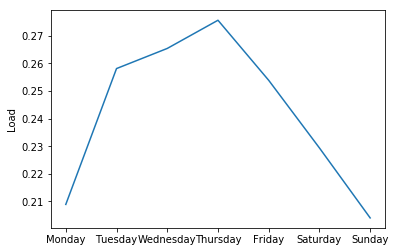

In [181]:
grouped_day = hourly_usage.groupby('day_of_week').mean()
plt.plot(grouped_day.index, grouped_day['best_time'])
# plt.xlabel('day_of_week')
my_xticks = ['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(grouped_day.index, my_xticks)
plt.ylabel('Load')
plt.show()

###### Observations - Monday and Sunday have the least load 

#### Compute weekend/weekday attribute

In [84]:
def isWeekend(timestamp):
    # Start time is May 1 2011 (19:00 EDT). It is a Sunday
#     print d.year, d.month, d.day, d.hour, d.second
# datetime.datetime(year, month, day[, hour[, minute[, second[, microsecond[, tzinfo]]]]])¶
    start_date = datetime.datetime(2011, 5, 1, 19, 0)
    datee = start_date + timedelta(microseconds = timestamp)
    day = datee.weekday()
    if day == 5 or day ==6:
        return 1
    return 0

#### H2

#### Calculate length of the job (schedule to finish)

In [182]:
def calculateJobLength(df):
    cols = ['start_time', 'jobID', 'task_index', 'job_length', 'is_weekend']
    job_ids = df['jobID'].unique()
    print("Total jobs = ", len(job_ids))
    result = pd.DataFrame(columns=cols)
    print("started loading")
    i = 0
    for job_id in job_ids:
#         print('JobID = ', job_id)
        i = i + 1
        small_df = df[df['jobID'] == job_id]
        tasks = small_df['task_index'].unique()
        for task in tasks:
            sched_time = small_df.loc[((small_df['task_index'] == task) & (small_df['event_type'] == 1)), 'timestamp']
            finish_time = small_df.loc[((small_df['task_index'] == task) & (small_df['event_type'] == 4)), 'timestamp']
#           print('empty')
            if not (sched_time.empty or finish_time.empty):
                runtime = finish_time.tolist()[0] - sched_time.tolist()[0]
                is_weekend = isWeekend(sched_time.tolist()[0])
                output_data = pd.DataFrame(columns=['start_time', 'jobID', 'task_index', 'job_length', 'is_weekend'],data=[[sched_time.tolist()[0],job_id,task,runtime, is_weekend]])
                result = result.append(output_data)
        print("jobs done = ", i)
        if i == 10000:
            return result
    return result

In [136]:
jobLength = calculateJobLength(task_data[(task_data['event_type'] == 1) | (task_data['event_type'] == 4)])

Total jobs =  666884
started loading
jobs done =  1
jobs done =  2
jobs done =  3
jobs done =  4
jobs done =  5
jobs done =  6
jobs done =  7
jobs done =  8
jobs done =  9
jobs done =  10
jobs done =  11
jobs done =  12
jobs done =  13
jobs done =  14
jobs done =  15
jobs done =  16
jobs done =  17
jobs done =  18
jobs done =  19
jobs done =  20
jobs done =  21
jobs done =  22
jobs done =  23
jobs done =  24
jobs done =  25
jobs done =  26
jobs done =  27
jobs done =  28
jobs done =  29
jobs done =  30
jobs done =  31
jobs done =  32
jobs done =  33
jobs done =  34
jobs done =  35
jobs done =  36
jobs done =  37
jobs done =  38
jobs done =  39
jobs done =  40
jobs done =  41
jobs done =  42
jobs done =  43
jobs done =  44
jobs done =  45
jobs done =  46
jobs done =  47
jobs done =  48
jobs done =  49
jobs done =  50
jobs done =  51
jobs done =  52
jobs done =  53
jobs done =  54
jobs done =  55
jobs done =  56
jobs done =  57
jobs done =  58
jobs done =  59
jobs done =  60
jobs done = 

jobs done =  490
jobs done =  491
jobs done =  492
jobs done =  493
jobs done =  494
jobs done =  495
jobs done =  496
jobs done =  497
jobs done =  498
jobs done =  499
jobs done =  500
jobs done =  501
jobs done =  502
jobs done =  503
jobs done =  504
jobs done =  505
jobs done =  506
jobs done =  507
jobs done =  508
jobs done =  509
jobs done =  510
jobs done =  511
jobs done =  512
jobs done =  513
jobs done =  514
jobs done =  515
jobs done =  516
jobs done =  517
jobs done =  518
jobs done =  519
jobs done =  520
jobs done =  521
jobs done =  522
jobs done =  523
jobs done =  524
jobs done =  525
jobs done =  526
jobs done =  527
jobs done =  528
jobs done =  529
jobs done =  530
jobs done =  531
jobs done =  532
jobs done =  533
jobs done =  534
jobs done =  535
jobs done =  536
jobs done =  537
jobs done =  538
jobs done =  539
jobs done =  540
jobs done =  541
jobs done =  542
jobs done =  543
jobs done =  544
jobs done =  545
jobs done =  546
jobs done =  547
jobs done =  5

jobs done =  973
jobs done =  974
jobs done =  975
jobs done =  976
jobs done =  977
jobs done =  978
jobs done =  979
jobs done =  980
jobs done =  981
jobs done =  982
jobs done =  983
jobs done =  984
jobs done =  985
jobs done =  986
jobs done =  987
jobs done =  988
jobs done =  989
jobs done =  990
jobs done =  991
jobs done =  992
jobs done =  993
jobs done =  994
jobs done =  995
jobs done =  996
jobs done =  997
jobs done =  998
jobs done =  999
jobs done =  1000
jobs done =  1001
jobs done =  1002
jobs done =  1003
jobs done =  1004
jobs done =  1005
jobs done =  1006
jobs done =  1007
jobs done =  1008
jobs done =  1009
jobs done =  1010
jobs done =  1011
jobs done =  1012
jobs done =  1013
jobs done =  1014
jobs done =  1015
jobs done =  1016
jobs done =  1017
jobs done =  1018
jobs done =  1019
jobs done =  1020
jobs done =  1021
jobs done =  1022
jobs done =  1023
jobs done =  1024
jobs done =  1025
jobs done =  1026
jobs done =  1027
jobs done =  1028
jobs done =  1029
j

jobs done =  1431
jobs done =  1432
jobs done =  1433
jobs done =  1434
jobs done =  1435
jobs done =  1436
jobs done =  1437
jobs done =  1438
jobs done =  1439
jobs done =  1440
jobs done =  1441
jobs done =  1442
jobs done =  1443
jobs done =  1444
jobs done =  1445
jobs done =  1446
jobs done =  1447
jobs done =  1448
jobs done =  1449
jobs done =  1450
jobs done =  1451
jobs done =  1452
jobs done =  1453
jobs done =  1454
jobs done =  1455
jobs done =  1456
jobs done =  1457
jobs done =  1458
jobs done =  1459
jobs done =  1460
jobs done =  1461
jobs done =  1462
jobs done =  1463
jobs done =  1464
jobs done =  1465
jobs done =  1466
jobs done =  1467
jobs done =  1468
jobs done =  1469
jobs done =  1470
jobs done =  1471
jobs done =  1472
jobs done =  1473
jobs done =  1474
jobs done =  1475
jobs done =  1476
jobs done =  1477
jobs done =  1478
jobs done =  1479
jobs done =  1480
jobs done =  1481
jobs done =  1482
jobs done =  1483
jobs done =  1484
jobs done =  1485
jobs done 

jobs done =  1889
jobs done =  1890
jobs done =  1891
jobs done =  1892
jobs done =  1893
jobs done =  1894
jobs done =  1895
jobs done =  1896
jobs done =  1897
jobs done =  1898
jobs done =  1899
jobs done =  1900
jobs done =  1901
jobs done =  1902
jobs done =  1903
jobs done =  1904
jobs done =  1905
jobs done =  1906
jobs done =  1907
jobs done =  1908
jobs done =  1909
jobs done =  1910
jobs done =  1911
jobs done =  1912
jobs done =  1913
jobs done =  1914
jobs done =  1915
jobs done =  1916
jobs done =  1917
jobs done =  1918
jobs done =  1919
jobs done =  1920
jobs done =  1921
jobs done =  1922
jobs done =  1923
jobs done =  1924
jobs done =  1925
jobs done =  1926
jobs done =  1927
jobs done =  1928
jobs done =  1929
jobs done =  1930
jobs done =  1931
jobs done =  1932
jobs done =  1933
jobs done =  1934
jobs done =  1935
jobs done =  1936
jobs done =  1937
jobs done =  1938
jobs done =  1939
jobs done =  1940
jobs done =  1941
jobs done =  1942
jobs done =  1943
jobs done 

jobs done =  2345
jobs done =  2346
jobs done =  2347
jobs done =  2348
jobs done =  2349
jobs done =  2350
jobs done =  2351
jobs done =  2352
jobs done =  2353
jobs done =  2354
jobs done =  2355
jobs done =  2356
jobs done =  2357
jobs done =  2358
jobs done =  2359
jobs done =  2360
jobs done =  2361
jobs done =  2362
jobs done =  2363
jobs done =  2364
jobs done =  2365
jobs done =  2366
jobs done =  2367
jobs done =  2368
jobs done =  2369
jobs done =  2370
jobs done =  2371
jobs done =  2372
jobs done =  2373
jobs done =  2374
jobs done =  2375
jobs done =  2376
jobs done =  2377
jobs done =  2378
jobs done =  2379
jobs done =  2380
jobs done =  2381
jobs done =  2382
jobs done =  2383
jobs done =  2384
jobs done =  2385
jobs done =  2386
jobs done =  2387
jobs done =  2388
jobs done =  2389
jobs done =  2390
jobs done =  2391
jobs done =  2392
jobs done =  2393
jobs done =  2394
jobs done =  2395
jobs done =  2396
jobs done =  2397
jobs done =  2398
jobs done =  2399
jobs done 

jobs done =  2803
jobs done =  2804
jobs done =  2805
jobs done =  2806
jobs done =  2807
jobs done =  2808
jobs done =  2809
jobs done =  2810
jobs done =  2811
jobs done =  2812
jobs done =  2813
jobs done =  2814
jobs done =  2815
jobs done =  2816
jobs done =  2817
jobs done =  2818
jobs done =  2819
jobs done =  2820
jobs done =  2821
jobs done =  2822
jobs done =  2823
jobs done =  2824
jobs done =  2825
jobs done =  2826
jobs done =  2827
jobs done =  2828
jobs done =  2829
jobs done =  2830
jobs done =  2831
jobs done =  2832
jobs done =  2833
jobs done =  2834
jobs done =  2835
jobs done =  2836
jobs done =  2837
jobs done =  2838
jobs done =  2839
jobs done =  2840
jobs done =  2841
jobs done =  2842
jobs done =  2843
jobs done =  2844
jobs done =  2845
jobs done =  2846
jobs done =  2847
jobs done =  2848
jobs done =  2849
jobs done =  2850
jobs done =  2851
jobs done =  2852
jobs done =  2853
jobs done =  2854
jobs done =  2855
jobs done =  2856
jobs done =  2857
jobs done 

jobs done =  3261
jobs done =  3262
jobs done =  3263
jobs done =  3264
jobs done =  3265
jobs done =  3266
jobs done =  3267
jobs done =  3268
jobs done =  3269
jobs done =  3270
jobs done =  3271
jobs done =  3272
jobs done =  3273
jobs done =  3274
jobs done =  3275
jobs done =  3276
jobs done =  3277
jobs done =  3278
jobs done =  3279
jobs done =  3280
jobs done =  3281
jobs done =  3282
jobs done =  3283
jobs done =  3284
jobs done =  3285
jobs done =  3286
jobs done =  3287
jobs done =  3288
jobs done =  3289
jobs done =  3290
jobs done =  3291
jobs done =  3292
jobs done =  3293
jobs done =  3294
jobs done =  3295
jobs done =  3296
jobs done =  3297
jobs done =  3298
jobs done =  3299
jobs done =  3300
jobs done =  3301
jobs done =  3302
jobs done =  3303
jobs done =  3304
jobs done =  3305
jobs done =  3306
jobs done =  3307
jobs done =  3308
jobs done =  3309
jobs done =  3310
jobs done =  3311
jobs done =  3312
jobs done =  3313
jobs done =  3314
jobs done =  3315
jobs done 

jobs done =  3719
jobs done =  3720
jobs done =  3721
jobs done =  3722
jobs done =  3723
jobs done =  3724
jobs done =  3725
jobs done =  3726
jobs done =  3727
jobs done =  3728
jobs done =  3729
jobs done =  3730
jobs done =  3731
jobs done =  3732
jobs done =  3733
jobs done =  3734
jobs done =  3735
jobs done =  3736
jobs done =  3737
jobs done =  3738
jobs done =  3739
jobs done =  3740
jobs done =  3741
jobs done =  3742
jobs done =  3743
jobs done =  3744
jobs done =  3745
jobs done =  3746
jobs done =  3747
jobs done =  3748
jobs done =  3749
jobs done =  3750
jobs done =  3751
jobs done =  3752
jobs done =  3753
jobs done =  3754
jobs done =  3755
jobs done =  3756
jobs done =  3757
jobs done =  3758
jobs done =  3759
jobs done =  3760
jobs done =  3761
jobs done =  3762
jobs done =  3763
jobs done =  3764
jobs done =  3765
jobs done =  3766
jobs done =  3767
jobs done =  3768
jobs done =  3769
jobs done =  3770
jobs done =  3771
jobs done =  3772
jobs done =  3773
jobs done 

jobs done =  4175
jobs done =  4176
jobs done =  4177
jobs done =  4178
jobs done =  4179
jobs done =  4180
jobs done =  4181
jobs done =  4182
jobs done =  4183
jobs done =  4184
jobs done =  4185
jobs done =  4186
jobs done =  4187
jobs done =  4188
jobs done =  4189
jobs done =  4190
jobs done =  4191
jobs done =  4192
jobs done =  4193
jobs done =  4194
jobs done =  4195
jobs done =  4196
jobs done =  4197
jobs done =  4198
jobs done =  4199
jobs done =  4200
jobs done =  4201
jobs done =  4202
jobs done =  4203
jobs done =  4204
jobs done =  4205
jobs done =  4206
jobs done =  4207
jobs done =  4208
jobs done =  4209
jobs done =  4210
jobs done =  4211
jobs done =  4212
jobs done =  4213
jobs done =  4214
jobs done =  4215
jobs done =  4216
jobs done =  4217
jobs done =  4218
jobs done =  4219
jobs done =  4220
jobs done =  4221
jobs done =  4222
jobs done =  4223
jobs done =  4224
jobs done =  4225
jobs done =  4226
jobs done =  4227
jobs done =  4228
jobs done =  4229
jobs done 

jobs done =  4633
jobs done =  4634
jobs done =  4635
jobs done =  4636
jobs done =  4637
jobs done =  4638
jobs done =  4639
jobs done =  4640
jobs done =  4641
jobs done =  4642
jobs done =  4643
jobs done =  4644
jobs done =  4645
jobs done =  4646
jobs done =  4647
jobs done =  4648
jobs done =  4649
jobs done =  4650
jobs done =  4651
jobs done =  4652
jobs done =  4653
jobs done =  4654
jobs done =  4655
jobs done =  4656
jobs done =  4657
jobs done =  4658
jobs done =  4659
jobs done =  4660
jobs done =  4661
jobs done =  4662
jobs done =  4663
jobs done =  4664
jobs done =  4665
jobs done =  4666
jobs done =  4667
jobs done =  4668
jobs done =  4669
jobs done =  4670
jobs done =  4671
jobs done =  4672
jobs done =  4673
jobs done =  4674
jobs done =  4675
jobs done =  4676
jobs done =  4677
jobs done =  4678
jobs done =  4679
jobs done =  4680
jobs done =  4681
jobs done =  4682
jobs done =  4683
jobs done =  4684
jobs done =  4685
jobs done =  4686
jobs done =  4687
jobs done 

jobs done =  5091
jobs done =  5092
jobs done =  5093
jobs done =  5094
jobs done =  5095
jobs done =  5096
jobs done =  5097
jobs done =  5098
jobs done =  5099
jobs done =  5100
jobs done =  5101
jobs done =  5102
jobs done =  5103
jobs done =  5104
jobs done =  5105
jobs done =  5106
jobs done =  5107
jobs done =  5108
jobs done =  5109
jobs done =  5110
jobs done =  5111
jobs done =  5112
jobs done =  5113
jobs done =  5114
jobs done =  5115
jobs done =  5116
jobs done =  5117
jobs done =  5118
jobs done =  5119
jobs done =  5120
jobs done =  5121
jobs done =  5122
jobs done =  5123
jobs done =  5124
jobs done =  5125
jobs done =  5126
jobs done =  5127
jobs done =  5128
jobs done =  5129
jobs done =  5130
jobs done =  5131
jobs done =  5132
jobs done =  5133
jobs done =  5134
jobs done =  5135
jobs done =  5136
jobs done =  5137
jobs done =  5138
jobs done =  5139
jobs done =  5140
jobs done =  5141
jobs done =  5142
jobs done =  5143
jobs done =  5144
jobs done =  5145
jobs done 

jobs done =  5549
jobs done =  5550
jobs done =  5551
jobs done =  5552
jobs done =  5553
jobs done =  5554
jobs done =  5555
jobs done =  5556
jobs done =  5557
jobs done =  5558
jobs done =  5559
jobs done =  5560
jobs done =  5561
jobs done =  5562
jobs done =  5563
jobs done =  5564
jobs done =  5565
jobs done =  5566
jobs done =  5567
jobs done =  5568
jobs done =  5569
jobs done =  5570
jobs done =  5571
jobs done =  5572
jobs done =  5573
jobs done =  5574
jobs done =  5575
jobs done =  5576
jobs done =  5577
jobs done =  5578
jobs done =  5579
jobs done =  5580
jobs done =  5581
jobs done =  5582
jobs done =  5583
jobs done =  5584
jobs done =  5585
jobs done =  5586
jobs done =  5587
jobs done =  5588
jobs done =  5589
jobs done =  5590
jobs done =  5591
jobs done =  5592
jobs done =  5593
jobs done =  5594
jobs done =  5595
jobs done =  5596
jobs done =  5597
jobs done =  5598
jobs done =  5599
jobs done =  5600
jobs done =  5601
jobs done =  5602
jobs done =  5603
jobs done 

jobs done =  6006
jobs done =  6007
jobs done =  6008
jobs done =  6009
jobs done =  6010
jobs done =  6011
jobs done =  6012
jobs done =  6013
jobs done =  6014
jobs done =  6015
jobs done =  6016
jobs done =  6017
jobs done =  6018
jobs done =  6019
jobs done =  6020
jobs done =  6021
jobs done =  6022
jobs done =  6023
jobs done =  6024
jobs done =  6025
jobs done =  6026
jobs done =  6027
jobs done =  6028
jobs done =  6029
jobs done =  6030
jobs done =  6031
jobs done =  6032
jobs done =  6033
jobs done =  6034
jobs done =  6035
jobs done =  6036
jobs done =  6037
jobs done =  6038
jobs done =  6039
jobs done =  6040
jobs done =  6041
jobs done =  6042
jobs done =  6043
jobs done =  6044
jobs done =  6045
jobs done =  6046
jobs done =  6047
jobs done =  6048
jobs done =  6049
jobs done =  6050
jobs done =  6051
jobs done =  6052
jobs done =  6053
jobs done =  6054
jobs done =  6055
jobs done =  6056
jobs done =  6057
jobs done =  6058
jobs done =  6059
jobs done =  6060
jobs done 

jobs done =  6462
jobs done =  6463
jobs done =  6464
jobs done =  6465
jobs done =  6466
jobs done =  6467
jobs done =  6468
jobs done =  6469
jobs done =  6470
jobs done =  6471
jobs done =  6472
jobs done =  6473
jobs done =  6474
jobs done =  6475
jobs done =  6476
jobs done =  6477
jobs done =  6478
jobs done =  6479
jobs done =  6480
jobs done =  6481
jobs done =  6482
jobs done =  6483
jobs done =  6484
jobs done =  6485
jobs done =  6486
jobs done =  6487
jobs done =  6488
jobs done =  6489
jobs done =  6490
jobs done =  6491
jobs done =  6492
jobs done =  6493
jobs done =  6494
jobs done =  6495
jobs done =  6496
jobs done =  6497
jobs done =  6498
jobs done =  6499
jobs done =  6500
jobs done =  6501
jobs done =  6502
jobs done =  6503
jobs done =  6504
jobs done =  6505
jobs done =  6506
jobs done =  6507
jobs done =  6508
jobs done =  6509
jobs done =  6510
jobs done =  6511
jobs done =  6512
jobs done =  6513
jobs done =  6514
jobs done =  6515
jobs done =  6516
jobs done 

jobs done =  6918
jobs done =  6919
jobs done =  6920
jobs done =  6921
jobs done =  6922
jobs done =  6923
jobs done =  6924
jobs done =  6925
jobs done =  6926
jobs done =  6927
jobs done =  6928
jobs done =  6929
jobs done =  6930
jobs done =  6931
jobs done =  6932
jobs done =  6933
jobs done =  6934
jobs done =  6935
jobs done =  6936
jobs done =  6937
jobs done =  6938
jobs done =  6939
jobs done =  6940
jobs done =  6941
jobs done =  6942
jobs done =  6943
jobs done =  6944
jobs done =  6945
jobs done =  6946
jobs done =  6947
jobs done =  6948
jobs done =  6949
jobs done =  6950
jobs done =  6951
jobs done =  6952
jobs done =  6953
jobs done =  6954
jobs done =  6955
jobs done =  6956
jobs done =  6957
jobs done =  6958
jobs done =  6959
jobs done =  6960
jobs done =  6961
jobs done =  6962
jobs done =  6963
jobs done =  6964
jobs done =  6965
jobs done =  6966
jobs done =  6967
jobs done =  6968
jobs done =  6969
jobs done =  6970
jobs done =  6971
jobs done =  6972
jobs done 

jobs done =  7374
jobs done =  7375
jobs done =  7376
jobs done =  7377
jobs done =  7378
jobs done =  7379
jobs done =  7380
jobs done =  7381
jobs done =  7382
jobs done =  7383
jobs done =  7384
jobs done =  7385
jobs done =  7386
jobs done =  7387
jobs done =  7388
jobs done =  7389
jobs done =  7390
jobs done =  7391
jobs done =  7392
jobs done =  7393
jobs done =  7394
jobs done =  7395
jobs done =  7396
jobs done =  7397
jobs done =  7398
jobs done =  7399
jobs done =  7400
jobs done =  7401
jobs done =  7402
jobs done =  7403
jobs done =  7404
jobs done =  7405
jobs done =  7406
jobs done =  7407
jobs done =  7408
jobs done =  7409
jobs done =  7410
jobs done =  7411
jobs done =  7412
jobs done =  7413
jobs done =  7414
jobs done =  7415
jobs done =  7416
jobs done =  7417
jobs done =  7418
jobs done =  7419
jobs done =  7420
jobs done =  7421
jobs done =  7422
jobs done =  7423
jobs done =  7424
jobs done =  7425
jobs done =  7426
jobs done =  7427
jobs done =  7428
jobs done 

jobs done =  7831
jobs done =  7832
jobs done =  7833
jobs done =  7834
jobs done =  7835
jobs done =  7836
jobs done =  7837
jobs done =  7838
jobs done =  7839
jobs done =  7840
jobs done =  7841
jobs done =  7842
jobs done =  7843
jobs done =  7844
jobs done =  7845
jobs done =  7846
jobs done =  7847
jobs done =  7848
jobs done =  7849
jobs done =  7850
jobs done =  7851
jobs done =  7852
jobs done =  7853
jobs done =  7854
jobs done =  7855
jobs done =  7856
jobs done =  7857
jobs done =  7858
jobs done =  7859
jobs done =  7860
jobs done =  7861
jobs done =  7862
jobs done =  7863
jobs done =  7864
jobs done =  7865
jobs done =  7866
jobs done =  7867
jobs done =  7868
jobs done =  7869
jobs done =  7870
jobs done =  7871
jobs done =  7872
jobs done =  7873
jobs done =  7874
jobs done =  7875
jobs done =  7876
jobs done =  7877
jobs done =  7878
jobs done =  7879
jobs done =  7880
jobs done =  7881
jobs done =  7882
jobs done =  7883
jobs done =  7884
jobs done =  7885
jobs done 

jobs done =  8288
jobs done =  8289
jobs done =  8290
jobs done =  8291
jobs done =  8292
jobs done =  8293
jobs done =  8294
jobs done =  8295
jobs done =  8296
jobs done =  8297
jobs done =  8298
jobs done =  8299
jobs done =  8300
jobs done =  8301
jobs done =  8302
jobs done =  8303
jobs done =  8304
jobs done =  8305
jobs done =  8306
jobs done =  8307
jobs done =  8308
jobs done =  8309
jobs done =  8310
jobs done =  8311
jobs done =  8312
jobs done =  8313
jobs done =  8314
jobs done =  8315
jobs done =  8316
jobs done =  8317
jobs done =  8318
jobs done =  8319
jobs done =  8320
jobs done =  8321
jobs done =  8322
jobs done =  8323
jobs done =  8324
jobs done =  8325
jobs done =  8326
jobs done =  8327
jobs done =  8328
jobs done =  8329
jobs done =  8330
jobs done =  8331
jobs done =  8332
jobs done =  8333
jobs done =  8334
jobs done =  8335
jobs done =  8336
jobs done =  8337
jobs done =  8338
jobs done =  8339
jobs done =  8340
jobs done =  8341
jobs done =  8342
jobs done 

jobs done =  8746
jobs done =  8747
jobs done =  8748
jobs done =  8749
jobs done =  8750
jobs done =  8751
jobs done =  8752
jobs done =  8753
jobs done =  8754
jobs done =  8755
jobs done =  8756
jobs done =  8757
jobs done =  8758
jobs done =  8759
jobs done =  8760
jobs done =  8761
jobs done =  8762
jobs done =  8763
jobs done =  8764
jobs done =  8765
jobs done =  8766
jobs done =  8767
jobs done =  8768
jobs done =  8769
jobs done =  8770
jobs done =  8771
jobs done =  8772
jobs done =  8773
jobs done =  8774
jobs done =  8775
jobs done =  8776
jobs done =  8777
jobs done =  8778
jobs done =  8779
jobs done =  8780
jobs done =  8781
jobs done =  8782
jobs done =  8783
jobs done =  8784
jobs done =  8785
jobs done =  8786
jobs done =  8787
jobs done =  8788
jobs done =  8789
jobs done =  8790
jobs done =  8791
jobs done =  8792
jobs done =  8793
jobs done =  8794
jobs done =  8795
jobs done =  8796
jobs done =  8797
jobs done =  8798
jobs done =  8799
jobs done =  8800
jobs done 

jobs done =  9202
jobs done =  9203
jobs done =  9204
jobs done =  9205
jobs done =  9206
jobs done =  9207
jobs done =  9208
jobs done =  9209
jobs done =  9210
jobs done =  9211
jobs done =  9212
jobs done =  9213
jobs done =  9214
jobs done =  9215
jobs done =  9216
jobs done =  9217
jobs done =  9218
jobs done =  9219
jobs done =  9220
jobs done =  9221
jobs done =  9222
jobs done =  9223
jobs done =  9224
jobs done =  9225
jobs done =  9226
jobs done =  9227
jobs done =  9228
jobs done =  9229
jobs done =  9230
jobs done =  9231
jobs done =  9232
jobs done =  9233
jobs done =  9234
jobs done =  9235
jobs done =  9236
jobs done =  9237
jobs done =  9238
jobs done =  9239
jobs done =  9240
jobs done =  9241
jobs done =  9242
jobs done =  9243
jobs done =  9244
jobs done =  9245
jobs done =  9246
jobs done =  9247
jobs done =  9248
jobs done =  9249
jobs done =  9250
jobs done =  9251
jobs done =  9252
jobs done =  9253
jobs done =  9254
jobs done =  9255
jobs done =  9256
jobs done 

jobs done =  9658
jobs done =  9659
jobs done =  9660
jobs done =  9661
jobs done =  9662
jobs done =  9663
jobs done =  9664
jobs done =  9665
jobs done =  9666
jobs done =  9667
jobs done =  9668
jobs done =  9669
jobs done =  9670
jobs done =  9671
jobs done =  9672
jobs done =  9673
jobs done =  9674
jobs done =  9675
jobs done =  9676
jobs done =  9677
jobs done =  9678
jobs done =  9679
jobs done =  9680
jobs done =  9681
jobs done =  9682
jobs done =  9683
jobs done =  9684
jobs done =  9685
jobs done =  9686
jobs done =  9687
jobs done =  9688
jobs done =  9689
jobs done =  9690
jobs done =  9691
jobs done =  9692
jobs done =  9693
jobs done =  9694
jobs done =  9695
jobs done =  9696
jobs done =  9697
jobs done =  9698
jobs done =  9699
jobs done =  9700
jobs done =  9701
jobs done =  9702
jobs done =  9703
jobs done =  9704
jobs done =  9705
jobs done =  9706
jobs done =  9707
jobs done =  9708
jobs done =  9709
jobs done =  9710
jobs done =  9711
jobs done =  9712
jobs done 

In [67]:
task_data[task_data['jobID'] == 6251639646]

,timestamp,jobID,task_index,machineID,event_type,priority
277381,604046280,6251639646,0,0,0,9
277397,605569015,6251639646,0,974254,1,9
278117,675251705,6251639646,0,974254,4,9


In [137]:
jobLength

,start_time,jobID,task_index,job_length,is_weekend
0,"277397 605569015 Name: timestamp, dtype: int64",6251639646,0,69682690,1
0,"277488 613690832 Name: timestamp, dtype: int64",6251668759,0,48575642,1
0,"277536 618605851 Name: timestamp, dtype: int64",6251668917,0,34678813,1
0,"277561 620915258 Name: timestamp, dtype: int64",6251668761,0,28114667,1
0,"277682 634642754 Name: timestamp, dtype: int64",6251668915,0,53219510,1
0,"277683 634642766 Name: timestamp, dtype: int64",6251669132,0,33934151,1
0,"277836 644356027 Name: timestamp, dtype: int64",6251669667,0,383492943,1
0,"277907 654976993 Name: timestamp, dtype: int64",6251668940,0,31337417,1
0,"277977 666219229 Name: timestamp, dtype: int64",6251670402,0,530766793,1
0,"278143 682003369 Name: timestamp, dtype: int64",6251500408,0,656549120,1


In [143]:
jobLength['jobID'] = jobLength['jobID'].astype(int)
jobLength['task_index'] = jobLength['task_index'].astype(int)
jobLength['job_length'] = jobLength['job_length'].astype(int)
jobLength['is_weekend'] = jobLength['is_weekend'].astype(int)

In [144]:
length_group = jobLength.groupby(['is_weekend']).mean()

In [145]:
length_group

,start_time,jobID,task_index,job_length
is_weekend,,,,
0,NaN,6.253662e+09,1282.672377,3.200392e+09
1,NaN,6.252141e+09,524.388554,1.395826e+09


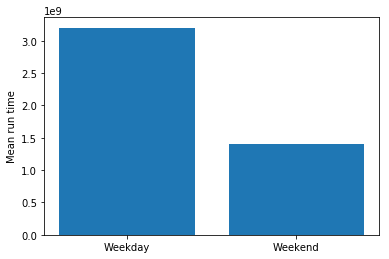

In [198]:
plt.bar(length_group.index, length_group['job_length'])
plt.xticks([0,1], ['Weekday', 'Weekend'])
plt.ylabel('Mean run time')
plt.show()

In [190]:
weekday_data = jobLength[jobLength['is_weekend']!=1]
weekend_data = jobLength[jobLength['is_weekend']==1]

walds_test(weekday_data['job_length'].tolist(),weekend_data['job_length'].tolist(),weekday_data['job_length'].mean(),weekend_data['job_length'].mean())


W value 83.60923834591779
